In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Bayesian General Linear Models

Bayes Theorem and Bayesian inference is used to determine posterior probability distributions. 

Here, Bayesian Inference is applied to a General Linear Model (GLM) for regression. 

### The Model
The objective is to *develop a model to predict student grades* given several input factors for student demographics. The publicly avaliable [UCI dataset](https://archive.ics.uci.edu/ml/datasets/student+performance#) contains grades and factors for 649 students taking a Portugese language course. 

In [2]:
os.listdir('./data')
raw = pd.read_csv('./data/student-por.csv',sep=';')

**Dependent variable or "Target"**
- "G3" is the students final grade for portugese (numeric: from 0 to 20, output target)

***Independent variables or "Features"***

A subset of numeric and categorical features is used to build the initial model:
- "age" student age from 15 to 22
- "internet"  student has internet access at home (binary: yes or no)
- "failures" is the number of past class failures (cat: n if 1<=n<3, else 4) 
- "higher" wants to take higher education (binary: yes or no) 
- "Medu" mother's education (cat: 0 - none, 1 - primary education (4th grade), 2 5th to 9th grade, 3 secondary education or 4 higher education)
-  ""Fedu father's education (cat: 0 - none, 1 - primary education (4th grade), 2 5th to 9th grade, 3 secondary education or 4 higher education)
-  "studytime" weekly study time (cat: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
- "absences" number of school absences (numeric: from 0 to 93) 

In [3]:
# prep Xy data
df = raw.loc[~raw['G3'].isin([0])].copy()
print(df.shape)

# prep features
categoricals = ['internet','failures','higher','Medu','Fedu','studytime']
reals = ['age','absences',]
features = categoricals+reals
target = ['G3']
df = df[features+target].copy()
df[:1]

(634, 33)


,internet,failures,higher,Medu,Fedu,studytime,age,absences,G3
0,no,0,yes,4,4,2,18,4,11


## PyMC3 OOS Predictions

- https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-2-b72059a8ac7e
- https://github.com/WillKoehrsen/Data-Analysis/blob/master/bayesian_lr/Bayesian%20Linear%20Regression%20Project.ipynb
- https://stackoverflow.com/questions/37312817/pymc3-bayesian-linear-regression-prediction-with-sklearn-datasets
- https://docs.pymc.io/notebooks/posterior_predictive.html?highlight=posterior%20predictive%20checks#Prediction
- https://stackoverflow.com/questions/33249122/generating-predictions-from-inferred-parameters-in-pymc3
- https://twiecki.io/blog/2013/08/12/bayesian-glms-1/
- https://www.sciencedirect.com/topics/mathematics/highest-density-interval

$y = a + b*x$

In [12]:
import pymc3 as pm
from theano import shared

***method 1: [Theano shared variable to update xtrain vairbale](https://stackoverflow.com/questions/37312817/pymc3-bayesian-linear-regression-prediction-with-sklearn-datasets)***

In [13]:
Xy = df[['G3','Fedu','studytime','age','absences']].copy()

train,test = Xy[:500],Xy[500:]
trainx,testx = train.drop(labels=['G3'],axis=1),test.drop(labels=['G3'],axis=1)
trainy,testy = train['G3'].copy(),test['G3'].copy()

# Shared variable for modelling
# must be np.array()
modelx = shared(np.array(trainx))

In [17]:
bglm = pm.Model()
with bglm:
    
    # Priors 
    alpha = pm.Normal('alpha', mu=0, sd=10)
    betas = pm.Normal('beta', mu=0, sd=10, shape=4)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Expected value of outcome (aka linear formula)
    mu = alpha + pm.math.dot(betas, modelx.T)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=trainy)
    
    # sample
    start = pm.find_MAP()   
    step = pm.NUTS()     
    trace = pm.sample(1000, tune=1000,step=step,start=start, random_seed=6)

logp = -1,170.6, ||grad|| = 6.6239: 100%|██████████| 49/49 [00:00<00:00, 1297.01it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:33<00:00, 119.82draws/s]


In [18]:
bglm

In [28]:
# Update model X and make Prediction
modelx.set_value(np.array(testx)) # update X data
ppc = pm.sample_ppc(trace, model=bglm, samples=25,random_seed=6)
ppc['y'].shape

<ipython-input-28-007d65506f48>:3: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  ppc = pm.sample_ppc(trace, model=bglm, samples=25,random_seed=6)
C:\Users\Ben\miniconda3\envs\ml\lib\site-packages\pymc3\sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████| 25/25 [00:00<00:00, 190.08it/s]


(25, 134)

In [29]:
pc = pm.sample_posterior_predictive(trace,model=bglm, var_names=["y"],samples=25,random_seed=6)
pc['y'].shape

100%|██████████| 25/25 [00:00<00:00, 190.03it/s]


(25, 134)

In [35]:
pc['y'] == ppc['y']

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [37]:
for i in range(3):
    print(pc['y'][i,:5])

[13.91702641 14.02366989 12.63622466 11.09656892 13.60494002]
[17.25271115 10.64090297 10.49682047 12.12298948 15.39954978]
[12.39414028  7.53577215 16.549973   12.5706986  12.46235575]


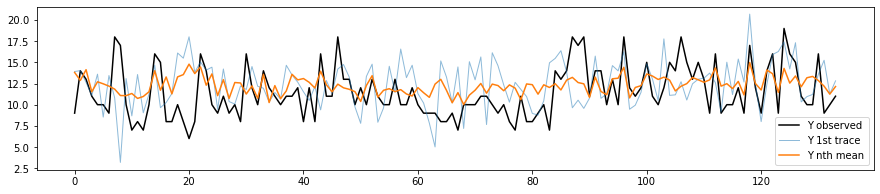

In [43]:
plt.figure(figsize=(15,3))
plt.plot(testy.reset_index(drop=True),'k-',label='Y observed')
plt.plot(pc['y'][0,:],lw=1,alpha=0.5,label='Y 1st trace')
plt.plot(pc['y'][:15,:].mean(axis=0),label='Y nth mean')
plt.legend();

### Where am i?

- was using glm, but struggled to create method 2 on oos data
- tried passing patsy to glm - failed
- trying using theano shared X - ok but shape above is 25,350,len(test) - which seems odd. - failed 
- this [nb](https://docs.pymc.io/notebooks/posterior_predictive.html?highlight=posterior%20predictive%20checks) suggest using pm.data

***method 2: [set data as variable and update](https://docs.pymc.io/notebooks/posterior_predictive.html?highlight=posterior%20predictive%20checks#Prediction)***

In [44]:
trainx.shape,trainy.shape

((500, 4), (500,))

In [121]:
bglm = pm.Model()
with bglm:
    
    # Priors 
    alpha = pm.Normal('alpha', mu=trainy.mean(), sd=50)
    betas = pm.Normal('beta', mu=0, sd=1000, shape=4)
    sigma = pm.HalfNormal('sigma', sd=1000)
    
    xdata = pm.Data("pred", trainx.T)
    
    # Expected value of outcome (aka linear formula)
    mu = alpha + pm.math.dot(betas, xdata)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=np.array(trainy).reshape(-1))
    
    # sample
    start = pm.find_MAP()   
    step = pm.NUTS()     
    trace = pm.sample(1000, tune=1000,step=step,start=start, random_seed=6)

logp = -1,194.3, ||grad|| = 0.033069: 100%|██████████| 42/42 [00:00<00:00, 1111.64it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:33<00:00, 120.03draws/s]


In [122]:
summary = pm.summary(trace)
summary[:5]

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,8.723,1.542,5.878,11.636,0.045,0.032,1164.0,1164.0,1173.0,1248.0,1.0
beta[0],0.447,0.104,0.274,0.657,0.003,0.002,1542.0,1542.0,1556.0,1113.0,1.0
beta[1],0.636,0.132,0.382,0.890,0.003,0.002,1669.0,1651.0,1669.0,1045.0,1.0
beta[2],0.103,0.090,-0.064,0.276,0.003,0.002,1104.0,1021.0,1105.0,1275.0,1.0
beta[3],-0.094,0.023,-0.137,-0.050,0.001,0.000,1881.0,1833.0,1862.0,1332.0,1.0


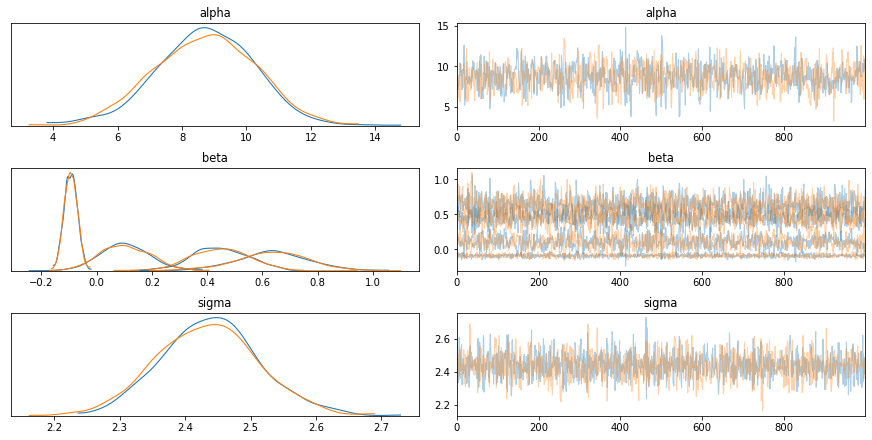

In [123]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pm.traceplot(trace)

In [124]:
with bglm:
    # update values of predictors:
    pm.set_data({"pred": testx.T})
    
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["y"], samples=600)
    model_preds = posterior_predictive["y"]

C:\Users\Ben\miniconda3\envs\ml\lib\site-packages\pymc3\sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████| 600/600 [00:02<00:00, 284.89it/s]


In [125]:
testx.shape,model_preds.shape

((134, 4), (600, 134))

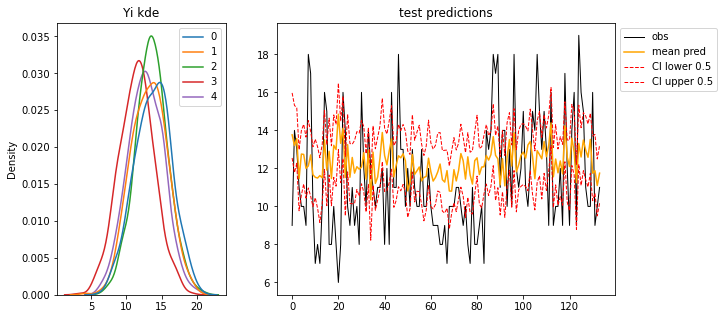

In [126]:
from matplotlib.gridspec import GridSpec

fig=plt.figure(figsize=(10,5))
gs=GridSpec(nrows=1,ncols=2,width_ratios=[1,2]) # 2 rows, 3 columns

ax0 = fig.add_subplot(gs[0])
ax0.set_title("Yi kde")
sns.kdeplot(data=pd.DataFrame(model_preds[:,:5]),ax=ax0)

ax1 = fig.add_subplot(gs[1])
ax1.set_title("test predictions")
ax1.plot(testy.reset_index(drop=True),'k-',lw=1,label='obs')
ax1.plot(model_preds.mean(0),c='orange',label='mean pred')

alpha = 1-0.5
ax1.plot(pm.hpd(model_preds,alpha)[:,0],ls='--',lw=1,c='red',label=f'CI lower {alpha}')
ax1.plot(pm.hpd(model_preds,alpha)[:,1],ls='--',lw=1,c='red',label=f'CI upper {alpha}')

ax1.legend(bbox_to_anchor=(1,1));

### try example from docs

In [105]:
from scipy.special import expit as logistic

N = 400
true_intercept = 0.2
true_slope = 1.0
predictors = np.random.normal(size=N)
true_p = logistic(true_intercept + true_slope * predictors)

outcomes = np.random.binomial(1, true_p)
outcomes[:10]

array([1, 0, 1, 1, 1, 0, 0, 1, 1, 0])

In [106]:
with pm.Model() as model_2:
    betas = pm.Normal("betas", mu=0.0, sigma=np.array([0.5, 1.0]), shape=2)

    # set predictors as shared variable to change them for PPCs:
    pred = pm.Data("pred", predictors)
    p = pm.Deterministic("p", pm.math.invlogit(betas[0] + betas[1] * pred))
    outcome = pm.Bernoulli("outcome", p=p, observed=outcomes)
    trace_2 = pm.sample(1000, tune=1000, random_seed=6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:07<00:00, 523.95draws/s]


In [107]:
predictors_out_of_sample = np.random.normal(size=50)
outcomes_out_of_sample = np.random.binomial(1, logistic(true_intercept + true_slope * predictors_out_of_sample))

with model_2:
    # update values of predictors:
    pm.set_data({"pred": predictors_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(trace_2, var_names=["p"], random_seed=6)
    model_preds = posterior_predictive["p"]

100%|██████████| 2000/2000 [00:00<00:00, 2243.63it/s]


In [108]:
model_preds.mean(0).shape

(50,)